In [253]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall
import scipy.fftpack as fp
from skimage.io import imread
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [228]:
tp = pd.read_csv('tp_list.txt', header=None)
au = pd.read_csv('au_list.txt', header=None)
file_path_au = "F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Au"
file_path_tp = "F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Tp"
au[0] = file_path_au + "\\" + au[0]
tp[0] = file_path_tp + "\\" + tp[0]
au.columns = ['file_path']
tp.columns = ['file_path']
au['type'] = 'Authentic'
tp['type'] = 'Forged'


In [229]:
#au = au.head(500)
#tp = tp.head(500)

In [230]:
im_df = pd.concat([au, tp], ignore_index=True)

In [231]:
import cv2
import numpy as np

def preprocess_image(image_path, output_size=(224, 224)):
    # Wczytanie obrazu w skali szarości i kolorowym (RGB)
    img_gray = cv2.imread(image_path, 0)  # Wczytanie w skali szarości
    img_rgb = cv2.imread(image_path)  # Wczytanie w trybie kolorowym
    img_rgb = cv2.resize(img_rgb, output_size)  # Skalowanie do (224, 224)

    # Przetwarzanie obrazu w skali szarości
    dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img_gray.shape    
    crow, ccol = int(rows / 2), int(cols / 2)
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 100  # Rozmiar maski - określa odcięcie HPF
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 0
    fshift = dft_shift * mask

    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    img_back = cv2.resize(img_back, output_size)  # Zmiana rozmiaru na 224x224

    # Normalizacja do zakresu [0, 255]
    img_normalized = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    img_normalized = np.uint8(img_normalized)  # Konwersja na typ uint8
    # return img_normalized
    # Stworzenie macierzy wynikowej o wymiarach (224, 224, 4)
    img_result = np.zeros((output_size[0], output_size[1], 4), dtype=np.uint8)
    img_result[:, :, :3] = img_rgb  # RGB (3 kanały)
    img_result[:, :, 3] = img_normalized  # Czwarty kanał - znormalizowany obraz
    return img_result
    


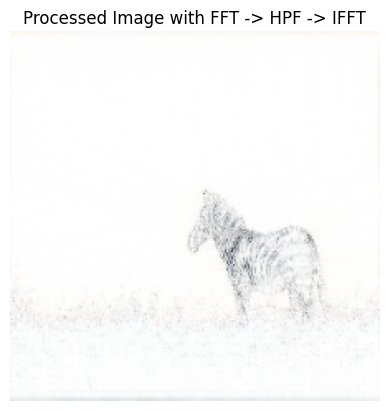

In [232]:
# Test funkcji
image_path = 'F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Au\\Au_ani_00001.jpg'  # Ścieżka do obrazu
processed_image = preprocess_image(image_path)

# Wyświetlenie przetworzonego obrazu
plt.imshow(processed_image, cmap='gray')
plt.title("Processed Image with FFT -> HPF -> IFFT")
plt.axis('off')
plt.show()

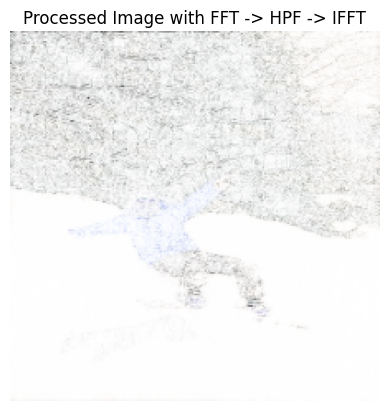

In [233]:
# Test funkcji
image_path = 'F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Tp\\Tp_D_CRD_S_N_cha00059_cha00057_00379.tif'  # Ścieżka do obrazu
processed_image = preprocess_image(image_path)

# Wyświetlenie przetworzonego obrazu
plt.imshow(processed_image, cmap='gray')
plt.title("Processed Image with FFT -> HPF -> IFFT")
plt.axis('off')
plt.show()

In [234]:
def save_image():
    labels = []
    imgs = []
    
    for i in range(len(im_df)):  # Załóżmy, że im_df jest dataframe
        labels.append(im_df['type'][i]) 
        img_normalized = preprocess_image(im_df['file_path'][i])  # Wczytanie obrazka za pomocą Keras
        imgs.append(img_normalized)
    
    return labels, imgs

In [235]:
#odzyskiwanie ramu
del tp
del au
del file_path_au
del file_path_tp

In [236]:
labels, imgs = save_image()

In [237]:
#odzyskiwanie ramu
del im_df

In [238]:
u = list(np.unique(labels)) #lsita unikalnych wartości w labels (red, green, other)

ilabels = np.asarray([u.index(l) for l in labels]) #utworzenie nowej listy zawierającyh wartości unikalne w postaci liczb, a nie tekstu

In [239]:
#odzyskiwanie ramu
del u
del labels

Kodu niżej nie uruchmiać jeśli nie ma się 32 GB RAMU, bo freezuje komputer

In [240]:
X = np.stack(imgs) / 255.0 - 0.5 #połączenie wszystkich osobnych list zawarty w imgs w jedną podzielenie wartości przez 255, ay otrzymać wartości od 0 do 1 i pomniejszenie wartości o 0.5 i otrzymanie od -0.5 do 0.5

In [241]:
del imgs

In [242]:

X_train, X_test, y_train, y_test = train_test_split(X, ilabels, test_size=0.33, shuffle=True, random_state=42) #podzielenie danych na treningowe i testowe, jak wyżej

In [243]:
del X
del ilabels

In [ ]:
# Tworzenie modelu Sequential
input_shape = (224, 224, 4)

model = Sequential([
    # Warstwa wejściowa
    InputLayer(input_shape=input_shape, name="conv2d_input"),

    # Pierwsza warstwa konwolucyjna
    Conv2D(25, (3, 3), activation='relu', name="conv2d"),  # Zakładamy 25 filtrów, (3x3)
    MaxPooling2D(pool_size=(2, 2), strides=1, padding='same', name="max_pooling2d"),  # Warstwa MaxPooling

    # Spłaszczenie
    Flatten(name="flatten"),  # Konwersja na jednowymiarowy wektor   

    # Warstwa gęsta (Dense)
    Dense(100, activation='relu', name="dense"),  # Pierwsza warstwa Dense (100 jednostek)
    Dropout(0.5, name="dropout"),
    Dense(100, activation='relu', name="dense_1"),  # Druga warstwa Dense
    Dropout(0.5, name="dropout_1"),
    Dense(100, activation='relu', name="dense_2"),  # Trzecia warstwa Dense
    Dense(1, activation='sigmoid', name="dense_3")  # Use softmax activation
])

# Kompilacja modelu z dodatkowymi metrykami
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-3), 
              metrics=['accuracy', AUC(), Precision(), Recall()])
            
# Podsumowanie modelu
model.summary()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 25)   │           925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 222, 222, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1232100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │   123,210,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,231,326 (470.09 MB)

 Trainable params: 123,231,326 (470.09 MB)

 Non-trainable params: 0 (0.00 B)

In [255]:
h = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True ))

Epoch 1/3
21/21 - 187s - 9s/step - accuracy: 0.5343 - auc: 0.5379 - loss: 10.4563 - precision: 0.5337 - recall: 0.5433 - val_accuracy: 0.4939 - val_auc: 0.5192 - val_loss: 1.2946 - val_precision: 0.4808 - val_recall: 0.1515
Epoch 2/3
21/21 - 110s - 5s/step - accuracy: 0.5060 - auc: 0.5178 - loss: 1.4176 - precision: 0.5054 - recall: 0.5552 - val_accuracy: 0.5182 - val_auc: 0.4992 - val_loss: 0.6973 - val_precision: 0.5234 - val_recall: 0.4061
Epoch 3/3
21/21 - 32s - 2s/step - accuracy: 0.5164 - auc: 0.5417 - loss: 0.7623 - precision: 0.5159 - recall: 0.5343 - val_accuracy: 0.6364 - val_auc: 0.6704 - val_loss: 0.6619 - val_precision: 0.6216 - val_recall: 0.6970


Training history plot saved as training_history.svg


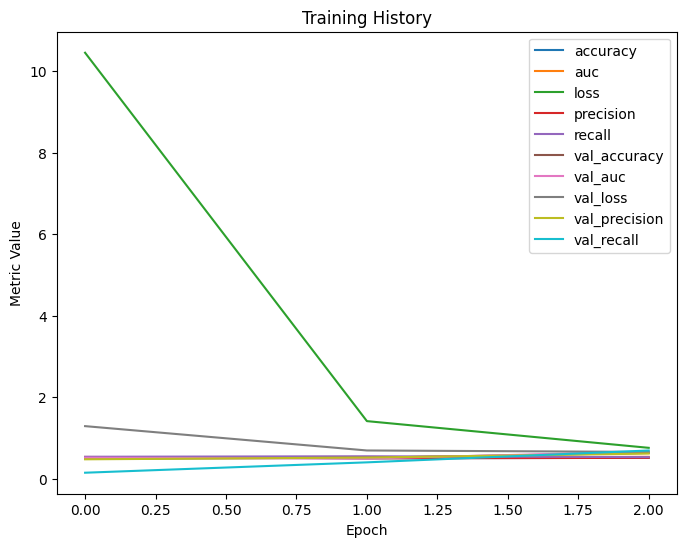

In [259]:
# Tworzenie DataFrame z historii trenowania
history_df = pd.DataFrame(h.history)

# Rysowanie wykresu
plot = history_df.plot(figsize=(8, 6), title="Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")

# Zapis do pliku SVG
plt.savefig('training_history.svg', format='svg')
print("Training history plot saved as training_history.svg")

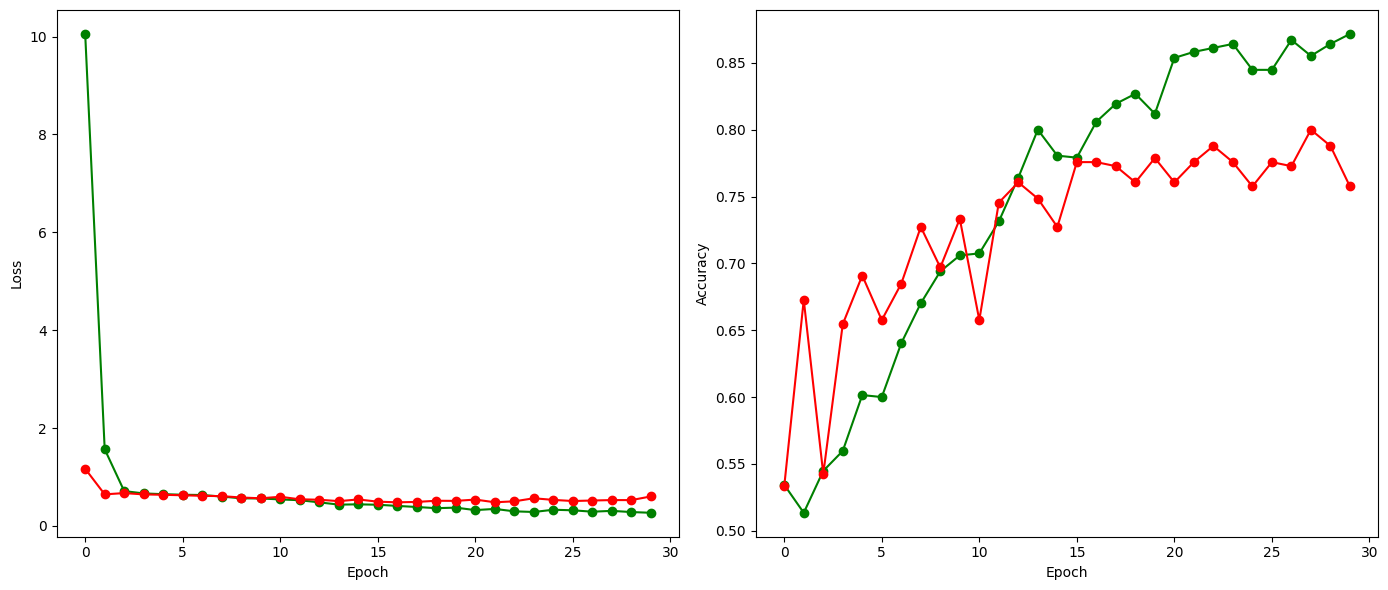

Training history with confidence intervals saved as training_history_with_ci.svg


In [249]:
# Tworzenie DataFrame z historii trenowania
history_df = pd.DataFrame(h.history)

# Obliczanie przedziałów ufności (np. 95%)
confidence_interval = 0.95
ci_bounds = int((1 - confidence_interval) * 100 / 2)

# Funkcja do obliczania przedziału ufności
def compute_confidence_interval(values):
    mean = np.mean(values)
    std = np.std(values)
    ci_range = std * 1.96  # 95% przedział ufności
    return mean - ci_range, mean + ci_range

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla loss
axes[0].plot(history_df['loss'], label='Loss', color='green', marker='o')
axes[0].plot(history_df['val_loss'], label='Loss', color='red', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Wykres dla accuracy
axes[1].plot(history_df['accuracy'], label='Accuracy', color='green', marker='o')
axes[1].plot(history_df['val_accuracy'], label='Accuracy', color='red', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Zapis do pliku SVG
plt.tight_layout()
plt.savefig('training_history_with_ci.svg', format='svg')
plt.show()

print("Training history with confidence intervals saved as training_history_with_ci.svg")


In [261]:
history_df.to_csv('fft.csv', index=False)

In [260]:
history_df

,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0.534328,0.537906,10.456311,0.533724,0.543284,0.493939,0.519155,1.294639,0.480769,0.151515
1,0.505970,0.517750,1.417605,0.505435,0.555224,0.518182,0.499155,0.697344,0.523438,0.406061
2,0.516418,0.541729,0.762269,0.515850,0.534328,0.636364,0.670450,0.661878,0.621622,0.696970
